**Author:** Boris Kundu

**Problem Statement:** Comparing different GRU models on Time-Series data

**Dataset:** COVID-19 hospitalizations

In [81]:
#Import packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [82]:
#Read data
data = np.genfromtxt('hospitalizations.txt', delimiter=' ')
hosp = data[:,1]

In [83]:
#Standardize data
mean = np.mean(hosp, axis=0)
std = np.std(hosp, axis=0)
hosp = (hosp - mean)/std

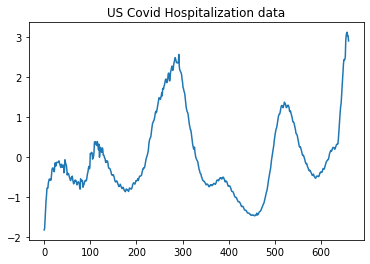

In [84]:
#Plot data
plt.plot(hosp)
plt.title('US Covid Hospitalization data')
plt.show()

In [85]:
#Parameters
last = len(hosp) #Total data points
seqlen = 20 # input size or window size
batchsize = 50 # data period and number of data points
trainbegin = np.random.randint(400) #Get random start day for training

In [86]:
#Preparing training data
Xtrain = np.array(hosp[trainbegin:trainbegin+seqlen])
ytrain = np.array(hosp[trainbegin+seqlen])
for i in range(1, batchsize):
    Xtrain = np.vstack([Xtrain, hosp[trainbegin+i:trainbegin+i+seqlen]])
    ytrain = np.append(ytrain, hosp[trainbegin+i+seqlen])

In [87]:
#Create tensors
X = torch.tensor(Xtrain, dtype=torch.float)
y = torch.tensor(ytrain, dtype=torch.float)
print(f'X Shape:{X.shape}')
print(f'Y Shape:{y.shape}')

X Shape:torch.Size([50, 20])
Y Shape:torch.Size([50])


In [88]:
#Input parameters
inputsize = 1
hiddensize = 10
outputsize = 1
epochs = 1000
X2 = torch.reshape(X.T, (seqlen, batchsize, inputsize))

In [89]:
#GRUCell model
class GRUCell(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(GRUCell, self).__init__()
        self.rnn = nn.GRUCell(inputsize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx = self.rnn(X2[i], hx)
        return self.layer2(hx)[:, 0]

In [90]:
#Define model
gruc = GRUCell(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_gruc = optim.Adam(gruc.parameters())

In [91]:
#Training model
def Train(model,epoch,optimizr,subject):
    for i in range(epoch):
        yhat = model(X2)
        L = F.mse_loss(yhat, y)
        if(i%100 == 0):
            print(f'{subject} Epoch:{i+1} with Loss:{L.item()}')
        optimizr.zero_grad()
        L.backward()
        optimizr.step()
    #Plot
    plotTrain(subject,yhat)

In [92]:
#Training Plot
def plotTrain(subject,yhat):
    plt.plot(y.detach().numpy())
    plt.plot(yhat.detach().numpy())
    plt.legend(['True','Predicted'])
    plt.title(f'{subject} - Training started at {str(trainbegin)}')
    plt.show()

GRUCell Epoch:1 with Loss:0.48373961448669434
GRUCell Epoch:101 with Loss:0.015722885727882385
GRUCell Epoch:201 with Loss:0.00829354114830494
GRUCell Epoch:301 with Loss:0.0017515345243737102
GRUCell Epoch:401 with Loss:0.0010982374660670757
GRUCell Epoch:501 with Loss:0.0010239058174192905
GRUCell Epoch:601 with Loss:0.0009983910713344812
GRUCell Epoch:701 with Loss:0.0010062315268442035
GRUCell Epoch:801 with Loss:0.0009912056848406792
GRUCell Epoch:901 with Loss:0.0009708019206300378


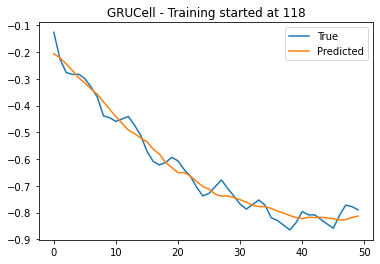

In [93]:
#Train GRUCell
Train(gruc,epochs,optimizer_gruc,'GRUCell')

In [94]:
#GRU model
class GRU(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(inputsize, hiddensize, 2)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(2, batchsize, hiddensize)
        output, _ = self.rnn(X2, hx)
        return self.layer2(output[seqlen - 1])[:, 0]

In [95]:
#Define model
gru = GRU(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_gru = optim.Adam(gru.parameters())

GRU Epoch:1 with Loss:0.3141365945339203
GRU Epoch:101 with Loss:0.015187961049377918
GRU Epoch:201 with Loss:0.0011271637631580234
GRU Epoch:301 with Loss:0.0010557315545156598
GRU Epoch:401 with Loss:0.0010532621527090669
GRU Epoch:501 with Loss:0.0010636767838150263
GRU Epoch:601 with Loss:0.0009648969280533493
GRU Epoch:701 with Loss:0.001016260590404272
GRU Epoch:801 with Loss:0.0010569243459030986
GRU Epoch:901 with Loss:0.0009776543593034148


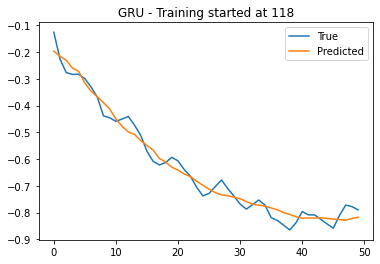

In [96]:
#Train LSTM
Train(gru,epochs,optimizer_gru,'GRU')

In [97]:
#Linear model
class Linear(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(Linear, self).__init__()
        self.resetgate = nn.Linear(inputsize + hiddensize, hiddensize)
        self.updategate = nn.Linear(inputsize + hiddensize, hiddensize)
        self.candidate = nn.Linear(inputsize + hiddensize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            inp = torch.cat((X2[i],hx),1)
            r = torch.sigmoid(self.resetgate(inp))
            z = torch.sigmoid(self.updategate(inp))
            inp1 = torch.cat((X2[i],r*hx),1)
            n = torch.tanh(self.candidate(inp1))
            hx = (1 - z) * n + z * hx
        return self.layer2(hx)[:, 0]

In [98]:
#Define model
lin = Linear(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_lin = optim.Adam(lin.parameters())

Linear Epoch:1 with Loss:0.5816715359687805
Linear Epoch:101 with Loss:0.023503560572862625
Linear Epoch:201 with Loss:0.017588192597031593
Linear Epoch:301 with Loss:0.011610533110797405
Linear Epoch:401 with Loss:0.004648955538868904
Linear Epoch:501 with Loss:0.0011089728213846684
Linear Epoch:601 with Loss:0.0010206717997789383
Linear Epoch:701 with Loss:0.0011157974367961287
Linear Epoch:801 with Loss:0.0010116227203980088
Linear Epoch:901 with Loss:0.0010205409489572048


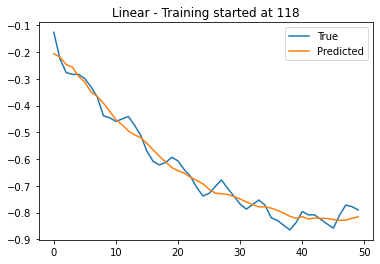

In [99]:
#Train Linear
Train(lin,epochs,optimizer_lin,'Linear')